In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.metrics import classification_report
import keras
from tensorflow.keras.utils import to_categorical

# Загрузка данных

In [2]:
_CIFAR_IMAGE_SIZE = 32
_CIFAR_IMAGE_SHAPE = (_CIFAR_IMAGE_SIZE, _CIFAR_IMAGE_SIZE, 3)
EPOCHS = 20
BATCH_SIZE = 100
NUM_F_CLASSES = 100
NUM_C_CLASSES = 20
opt = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [52]:
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict


def show_data_item(data):
    for item in data:
        print(item, type(data[item]))


def load_data(data):
    X, CY, FY = data['data'], np.array(data['coarse_labels']), np.array(data['fine_labels'])
    return X, CY, FY


def load_classes(classes):
    C_label, F_label = np.array(classes['coarse_label_names']), np.array(classes['fine_label_names'])
    return C_label, F_label


def preview_images(classnames, label, images,title):
    plt.figure(title,figsize=(20,16))
    for i in range(80):
        plt.subplot(8,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classnames[label[i]], labelpad=2, fontsize=6)
    plt.show()


def create_model(num_classes):
    model = Sequential()

    model.add(Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=_CIFAR_IMAGE_SHAPE))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


def model_compile(model, opt, loss, metrics):
    model.compile(optimizer=opt, 
                loss=loss,
                metrics= metrics)
    return model

In [4]:
X_train, CY_train, FY_train = load_data(unpickle('cifar-100-python/train'))
print(X_train.shape, CY_train.shape, FY_train.shape)

(50000, 3072) (50000,) (50000,)


In [5]:
X_train = X_train.reshape(len(X_train),3,_CIFAR_IMAGE_SIZE,_CIFAR_IMAGE_SIZE).transpose(0,2,3,1)
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test, CY_test, FY_test = load_data(unpickle('cifar-100-python/test'))
print(X_test.shape, CY_test.shape, FY_test.shape)

(10000, 3072) (10000,) (10000,)


In [7]:
X_test = X_test.reshape(len(X_test),3,_CIFAR_IMAGE_SIZE,_CIFAR_IMAGE_SIZE).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [53]:
C_label, F_label = load_classes(unpickle('cifar-100-python/meta'))

# Визуализция датасета

Вывод изображений с узкими классами

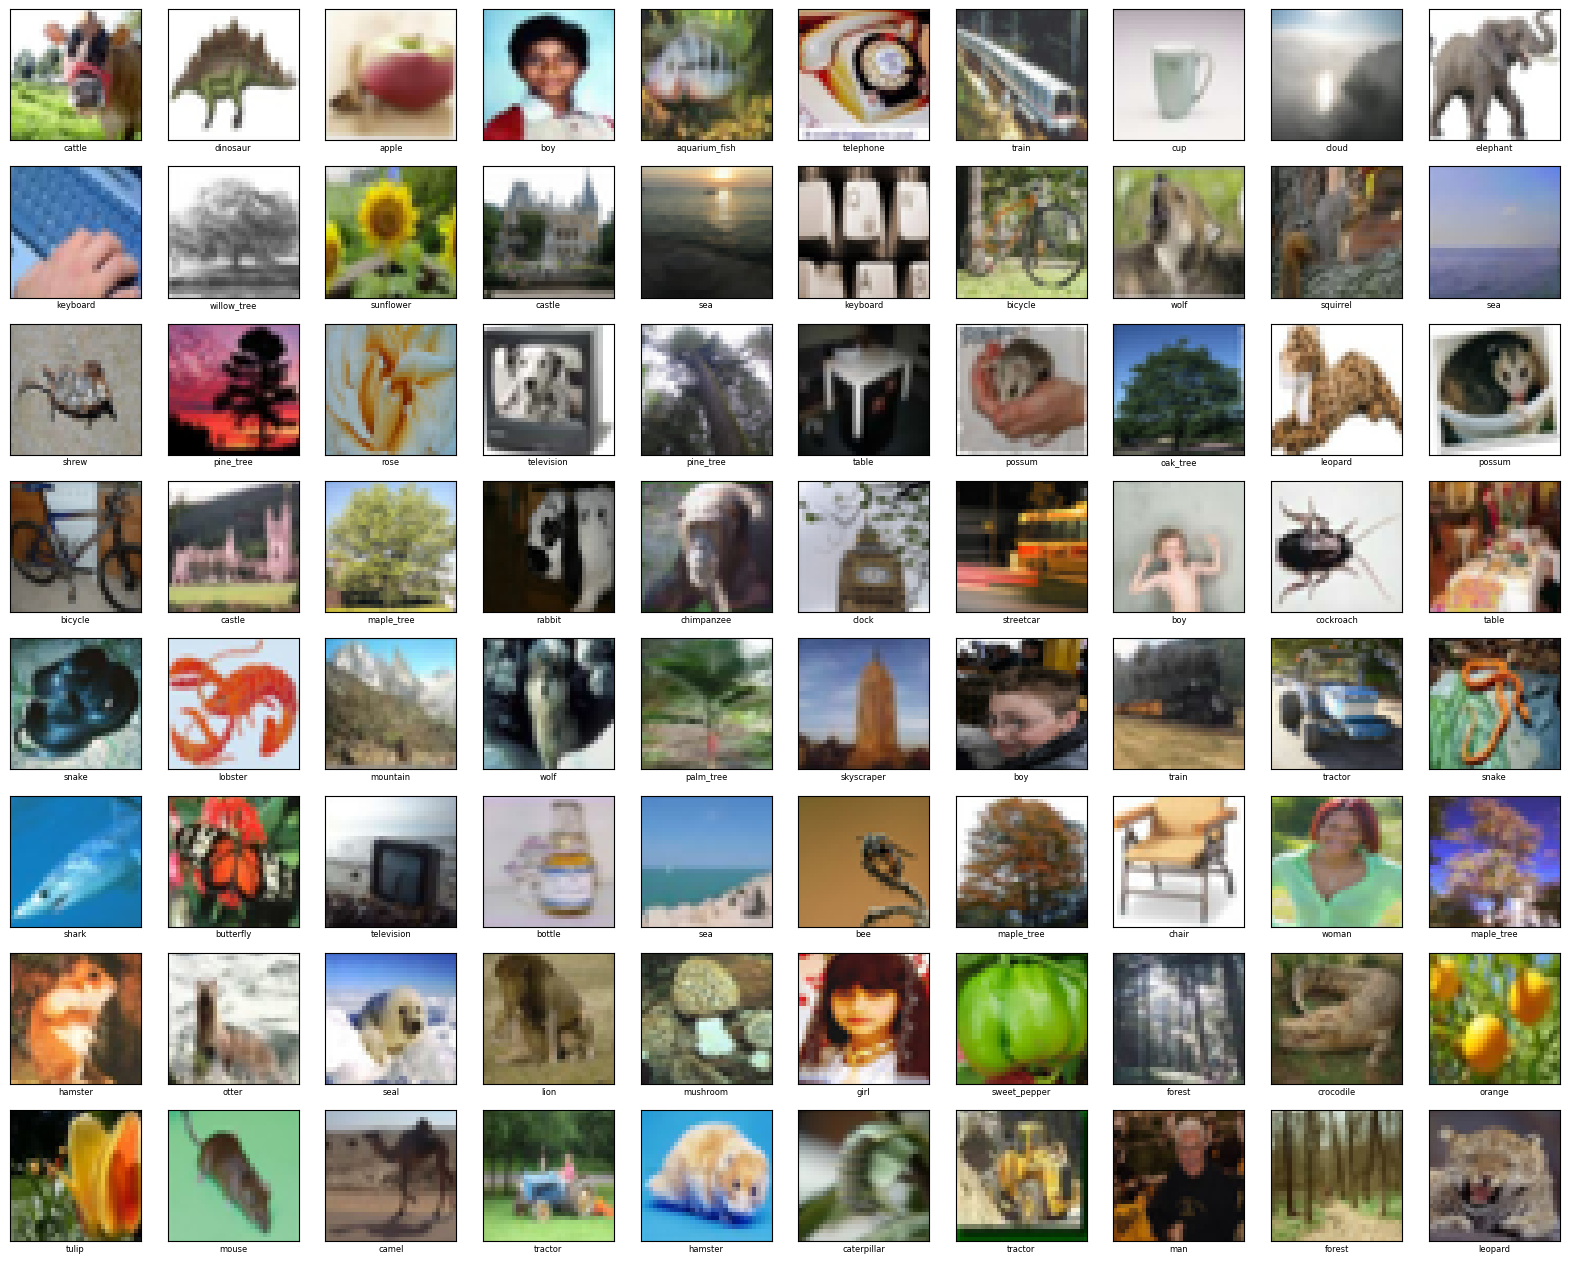

In [9]:
preview_images(F_label, FY_train, X_train, 'Fine classes')

Вывод изображений с широкими классами

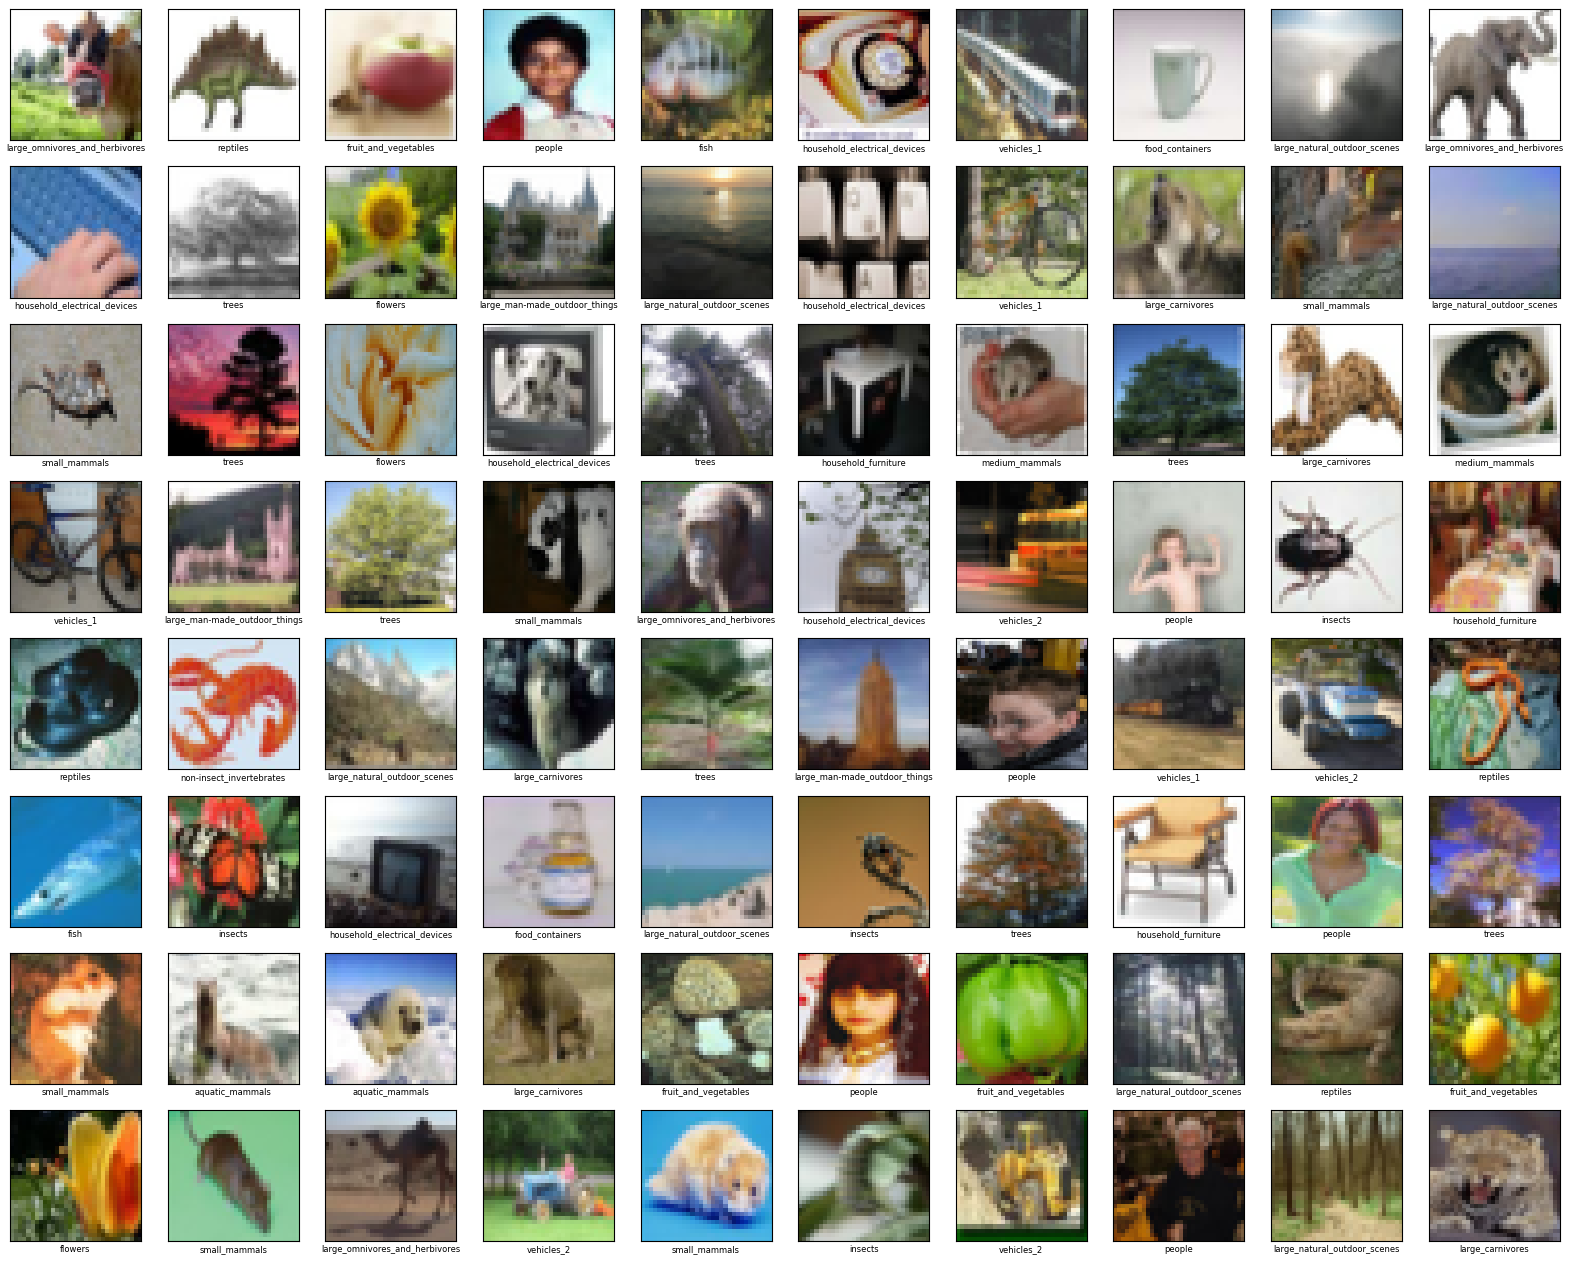

In [10]:
preview_images(C_label, CY_train, X_train, 'Coarse classes')

## Нормализация X_train, X_test и one-hot encoding 

In [11]:
X_train = X_train.astype('float32') / 255.0
CY_train_ = to_categorical(CY_train, NUM_C_CLASSES)
FY_train_ = to_categorical(FY_train, NUM_F_CLASSES)

X_test = X_test.astype('float32') / 255.0
CY_test_ = to_categorical(CY_test, NUM_C_CLASSES)
FY_test_ = to_categorical(FY_test, NUM_F_CLASSES)

# Построение модели

Модель для классификации на широкие классы

In [12]:
C_model = model_compile(create_model(NUM_C_CLASSES), opt, loss, metrics)
print('C_model', C_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 128)         46592     
                                                                 
 batch_normalization (Batch  (None, 6, 6, 128)         512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 128)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 256)         819456    
                                                                 
 batch_normalization_1 (Bat  (None, 3, 3, 256)         1024      
 chNormalization)                                                
                                                        

### **Выбор гиперпараметров:**

Здесь используется сверточная нейронная сеть (CNN) для обработки изображений.

Давайте разберемся с каждым слоем вашей модели и обоснуем выбор гиперпараметров.

1. **Слой Conv2D (фильтры=128, размер ядра=(11,11), шаг=(4,4), активация='relu', входной размер=(32,32,3))**:
    - `filters=128`: Это количество фильтров (или ядер), которые будут применены к входным данным. Большее количество фильтров может помочь изучить более сложные признаки.
    - `kernel_size=(11,11)`: Это размер ядра свертки. Большие ядра помогают модели извлекать более крупные признаки из входных данных.
    - `strides=(4,4)`: Это шаг, с которым фильтры перемещаются по входным данным. Больший шаг уменьшает размерность выходных данных.
    - `activation='relu'`: Функция активации ReLU применяется после свертки, чтобы внести нелинейность в модель.

2. **Слой BatchNormalization**:
    - Использование `BatchNormalization` после сверточных слоев помогает ускорить обучение и улучшить обобщение модели.

3. **Слой MaxPooling2D (pool_size=(2,2))**:
    - Пулинг используется для уменьшения размерности данных и извлечения наиболее важных признаков. `pool_size=(2,2)` означает, что будет использоваться пулинг с размером окна 2x2.

4. **Слой Conv2D (фильтры=256, размер ядра=(5,5), шаг=(1,1), активация='relu', padding="same")**:
    - `filters=256`: Увеличение количества фильтров для изучения более сложных признаков.
    - `kernel_size=(5,5)`: Уменьшение размера ядра для более локальных признаков.
    - `strides=(1,1)`: Используется меньший шаг для более тщательного изучения данных.
    - `padding="same"`: Заполнение нулями вокруг входных данных, чтобы сохранить размерность.

5. **Слой BatchNormalization**:
    - Опять же, BatchNormalization помогает стабилизировать процесс обучения.

6. **Слой MaxPooling2D (pool_size=(2,2))**:
    - Повторный пулинг для уменьшения размерности данных.

7. **Слой Flatten**:
    - Преобразует двумерные данные в одномерный вектор перед подачей их на полносвязные слои.

8. **Полносвязный слой Dense (1024 нейрона, активация='relu')**:
    - 1024 нейрона для извлечения высокоуровневых признаков.
    - Функция активации ReLU для введения нелинейности.

9. **Слой Dropout (0.5)**:
    - Dropout используется для уменьшения переобучения путем случайного обнуления половины нейронов.

10. **Полносвязный слой Dense (1024 нейрона, активация='relu')**:
    - Аналогично предыдущему полносвязному слою.

11. **Слой Dropout (0.5)**:
    - Дополнительный слой Dropout для уменьшения переобучения.

12. **Полносвязный слой Dense (100 нейронов, активация='softmax')**:
    - Выходной слой с 20 нейронами (20 классов) и функцией активации softmax для многоклассовой классификации. Для модели с 100 классами будет 100 нейронов, т.к. там 100 классов.

Обучаем модель

In [14]:
history = C_model.fit(X_train, CY_train_, epochs=EPOCHS, batch_size= BATCH_SIZE)

Epoch 1/20
500/500 [==============================] - 78s 156ms/step - loss: 0.8571 - accuracy: 0.7215
Epoch 2/20
500/500 [==============================] - 76s 152ms/step - loss: 0.8130 - accuracy: 0.7338
Epoch 3/20
500/500 [==============================] - 81s 162ms/step - loss: 0.7769 - accuracy: 0.7440
Epoch 4/20
500/500 [==============================] - 86s 171ms/step - loss: 0.7496 - accuracy: 0.7538
Epoch 5/20
500/500 [==============================] - 76s 153ms/step - loss: 0.7105 - accuracy: 0.7642
Epoch 6/20
500/500 [==============================] - 77s 154ms/step - loss: 0.6922 - accuracy: 0.7709
Epoch 7/20
500/500 [==============================] - 76s 153ms/step - loss: 0.6612 - accuracy: 0.7825
Epoch 8/20
500/500 [==============================] - 76s 152ms/step - loss: 0.6357 - accuracy: 0.7890
Epoch 9/20
500/500 [==============================] - 76s 153ms/step - loss: 0.6137 - accuracy: 0.7983
Epoch 10/20
500/500 [==============================] - 76s 152ms/step - l

Сохраняем обученную модель в C_model.keras

In [ ]:
C_model.save("C_model.keras")
# C_model = keras.models.load_model('C_model.keras')

Проверяем модель на тестовых данных

In [16]:
C_test_loss, C_test_acc = C_model.evaluate(X_test, CY_test_)
print('Точность на тестовых данных(широкие классы):', C_test_acc)

313/313 [==============================] - 3s 11ms/step - loss: 2.7049 - accuracy: 0.4429
Точность на тестовых данных(широкие классы): 0.44290000200271606


In [17]:
CY_predictions = np.argmax(C_model.predict(X_test), axis = -1)
print(classification_report(CY_test, CY_predictions, target_names = C_label))

313/313 [==============================] - 4s 11ms/step
                                precision    recall  f1-score   support

               aquatic_mammals       0.34      0.39      0.36       500
                          fish       0.45      0.43      0.44       500
                       flowers       0.70      0.60      0.65       500
               food_containers       0.46      0.40      0.43       500
          fruit_and_vegetables       0.55      0.47      0.51       500
  household_electrical_devices       0.41      0.36      0.38       500
           household_furniture       0.48      0.51      0.50       500
                       insects       0.50      0.40      0.45       500
              large_carnivores       0.33      0.31      0.32       500
 large_man-made_outdoor_things       0.47      0.59      0.53       500
  large_natural_outdoor_scenes       0.57      0.71      0.63       500
large_omnivores_and_herbivores       0.34      0.38      0.36       500
       

Модель для классификации на узкие классы

In [18]:
F_model = model_compile(create_model(NUM_F_CLASSES), opt, loss, metrics)
print('F_model', F_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         46592     
                                                                 
 batch_normalization_2 (Bat  (None, 6, 6, 128)         512       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 256)         819456    
                                                                 
 batch_normalization_3 (Bat  (None, 3, 3, 256)         1024      
 chNormalization)                                                
                                                      

Обучаем модель

In [19]:
history = F_model.fit(X_train, FY_train_, epochs=EPOCHS, batch_size= BATCH_SIZE)

Epoch 1/20
500/500 [==============================] - 76s 149ms/step - loss: 3.9708 - accuracy: 0.0960
Epoch 2/20
500/500 [==============================] - 74s 148ms/step - loss: 3.4856 - accuracy: 0.1684
Epoch 3/20
500/500 [==============================] - 74s 149ms/step - loss: 3.2363 - accuracy: 0.2136
Epoch 4/20
500/500 [==============================] - 74s 148ms/step - loss: 3.0581 - accuracy: 0.2479
Epoch 5/20
500/500 [==============================] - 75s 150ms/step - loss: 2.8875 - accuracy: 0.2784
Epoch 6/20
500/500 [==============================] - 75s 150ms/step - loss: 2.7543 - accuracy: 0.3034
Epoch 7/20
500/500 [==============================] - 74s 149ms/step - loss: 2.6307 - accuracy: 0.3311
Epoch 8/20
500/500 [==============================] - 73s 146ms/step - loss: 2.5211 - accuracy: 0.3502
Epoch 9/20
500/500 [==============================] - 74s 148ms/step - loss: 2.4197 - accuracy: 0.3705
Epoch 10/20
500/500 [==============================] - 73s 146ms/step - l

Сохраняем обученную модель в F_model.keras

In [ ]:
F_model.save("F_model.keras")
# F_model = keras.models.load_model('F_model.keras')

Проверяем модель на тестовых данных

In [20]:
F_test_loss, F_test_acc = F_model.evaluate(X_test, FY_test_)
print('Точность на тестовых данных(широкие классы):', F_test_acc)

313/313 [==============================] - 4s 11ms/step - loss: 2.7015 - accuracy: 0.3673
Точность на тестовых данных(широкие классы): 0.36730000376701355


In [66]:
FY_predictions = np.argmax(F_model.predict(X_test), axis = -1)
print(classification_report(FY_test, FY_predictions, target_names = F_label))
F_report = classification_report(FY_test, FY_predictions, target_names=F_label, output_dict = True)

313/313 [==============================] - 4s 11ms/step
               precision    recall  f1-score   support

        apple       0.63      0.64      0.64       100
aquarium_fish       0.49      0.47      0.48       100
         baby       0.27      0.34      0.30       100
         bear       0.23      0.15      0.18       100
       beaver       0.26      0.14      0.18       100
          bed       0.31      0.29      0.30       100
          bee       0.51      0.28      0.36       100
       beetle       0.41      0.34      0.37       100
      bicycle       0.46      0.32      0.38       100
       bottle       0.52      0.48      0.50       100
         bowl       0.32      0.17      0.22       100
          boy       0.32      0.10      0.15       100
       bridge       0.26      0.45      0.33       100
          bus       0.41      0.24      0.30       100
    butterfly       0.32      0.20      0.25       100
        camel       0.22      0.28      0.24       100
        

In [67]:
# Определение по узкой категории широкой
def init_fine_map():
    map = {
        "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
        "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
        "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
        "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
        "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
        "household_electrical_devices": ["clock", "keyboard", "lamp", "telephone", "television"],
        "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
        "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
        "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
        "large_man-made_outdoor_things": ["bridge", "castle", "house", "road", "skyscraper"],
        "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
        "large_omnivores_and_herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
        "medium_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
        "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
        "people": ["baby", "boy", "girl", "man", "woman"],
        "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
        "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
        "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
        "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
        "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
    }
    dict = {}
    for label in F_label:
        for key in map:
            if label in map[key]:
                dict.update({label: key})
                break
    return dict

fine_to_coarse = init_fine_map()

In [68]:
FC = lambda i: fine_to_coarse[F_label[i]]
CF_predictions = np.array([FC(i) for i in FY_predictions])
C_index = lambda i: np.where(C_label == i)[0][0]

CF_predictions = np.array([C_index(i) for i in CF_predictions])

##### Оценка обобщенных предсказаний по узким меткам до метки их широкого класса

In [69]:
print(classification_report(CY_test, CF_predictions, target_names=C_label))
CF_report = classification_report(CY_test, CF_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.47      0.35      0.40       500
                          fish       0.52      0.50      0.51       500
                       flowers       0.68      0.66      0.67       500
               food_containers       0.53      0.46      0.49       500
          fruit_and_vegetables       0.55      0.60      0.57       500
  household_electrical_devices       0.38      0.47      0.42       500
           household_furniture       0.48      0.59      0.53       500
                       insects       0.57      0.46      0.51       500
              large_carnivores       0.38      0.38      0.38       500
 large_man-made_outdoor_things       0.50      0.69      0.58       500
  large_natural_outdoor_scenes       0.62      0.68      0.65       500
large_omnivores_and_herbivores       0.38      0.42      0.40       500
                medium_mammals       0.38      0.42      0.40  

##### Оценка предсказаний при обучении на широких метках

In [76]:
print(classification_report(CY_test, CY_predictions, target_names=C_label))
C_report = classification_report(CY_test, CY_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.34      0.39      0.36       500
                          fish       0.45      0.43      0.44       500
                       flowers       0.70      0.60      0.65       500
               food_containers       0.46      0.40      0.43       500
          fruit_and_vegetables       0.55      0.47      0.51       500
  household_electrical_devices       0.41      0.36      0.38       500
           household_furniture       0.48      0.51      0.50       500
                       insects       0.50      0.40      0.45       500
              large_carnivores       0.33      0.31      0.32       500
 large_man-made_outdoor_things       0.47      0.59      0.53       500
  large_natural_outdoor_scenes       0.57      0.71      0.63       500
large_omnivores_and_herbivores       0.34      0.38      0.36       500
                medium_mammals       0.31      0.34      0.32  

Общая точность предсказания в обоих случаях одинакова и составляет 0.44.

#### Исследование с помощью графиков метрики предсказания для каких узких классов более всего отличаются от метрик их более широких классов

In [71]:
# Точность распознавания узкого класса
F_precision =  lambda i: F_report[i]['precision']
F_precisions = np.array([F_precision(i) for i in F_label])

#Точность распознавания широкого класса по узкому
CF_precision =  lambda i: CF_report[fine_to_coarse[i]]['precision']
CF_precisions = np.array([CF_precision(i) for i in F_label])

# Точность распознавания соответствующего широкого класса
C_precision =  lambda i: C_report[fine_to_coarse[i]]['precision']
C_precisions = np.array([C_precision(i) for i in F_label])

<Axes: >

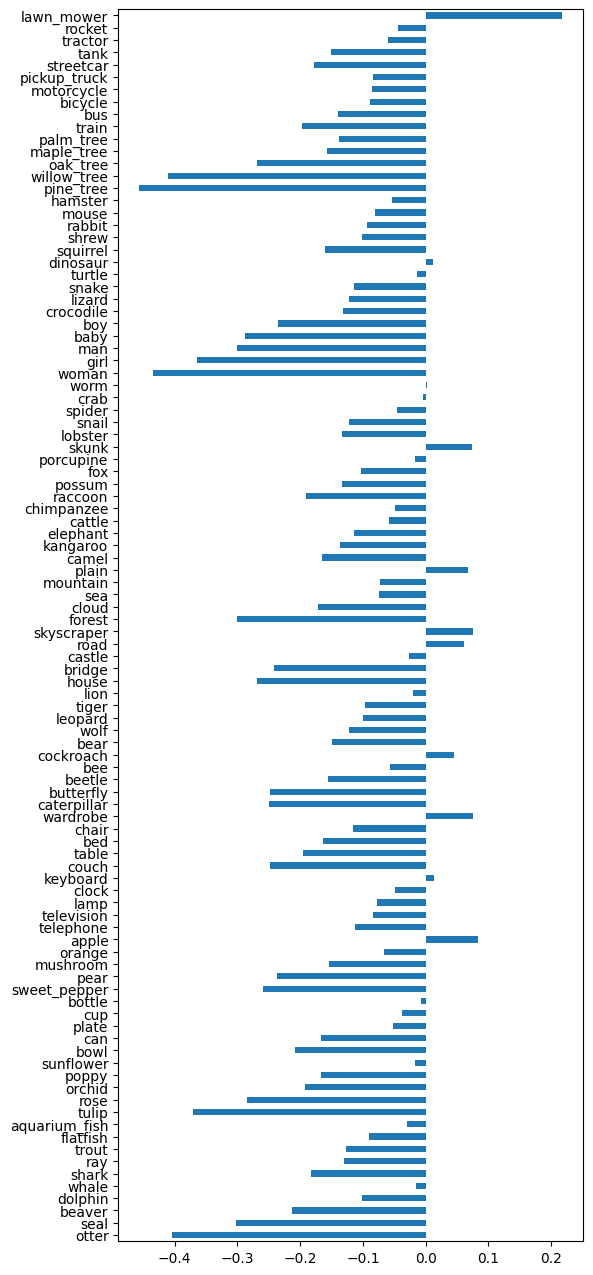

In [72]:
df = pd.DataFrame(
    {
        'label': F_label,
        'c_label': np.array([fine_to_coarse[i] for i in F_label]),
        'F_CF': F_precisions - CF_precisions,
        'F_C': F_precisions - C_precisions,
        'CF_C': CF_precisions - C_precisions,
    })

# График различия точности распознавания узкого класса и точности распознавания широкого класса по узкому
df.sort_values(by=['c_label', 'F_CF'],ascending=True).plot.barh(y='F_CF', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса по узкому и позволяет сделать вывод, насколько точно определяется узкий класс в рамках широкого. Наибольший разброс имеют элементы широкого класса деревьев (trees) и людей (people), это говорит о том, что конкретный вид деревьев и людей между собой данная сеть определяет плохо. Наименьшее отклонение имеют следующие узкие классы dinosaur, turtle, worm, crab, porcupine, castle, lion, cockroach, keyboard, bottle, sunflower, whale, aquarium_fish сеть определяет хорошо. 

<Axes: >

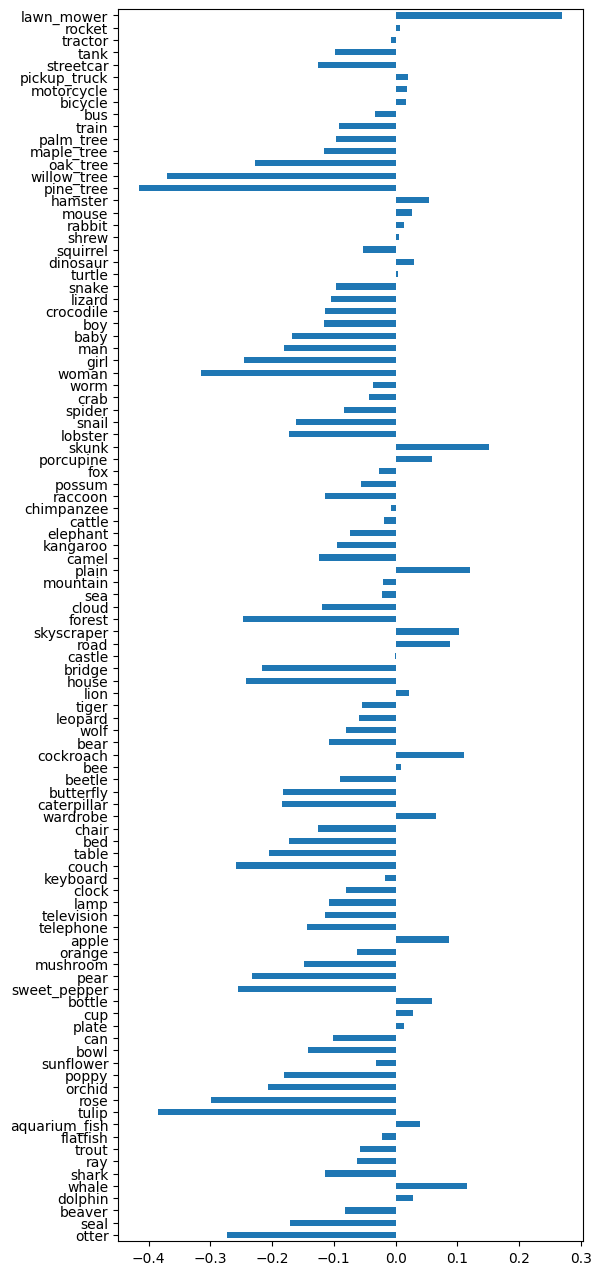

In [73]:
# График различия точности распознавания узкого класса и точности распознавания широкого класса
df.sort_values(by=['c_label', 'F_C'],ascending=True).plot.barh(y='F_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса и позволяет сделать вывод о том, что модель определяет лучше широкие классы или узкие. Например, изображения dinosaur, turtle определяются с примерно одинаковой точностью, как в случае распознавания по узкому классу, так и по широкому.

<Axes: >

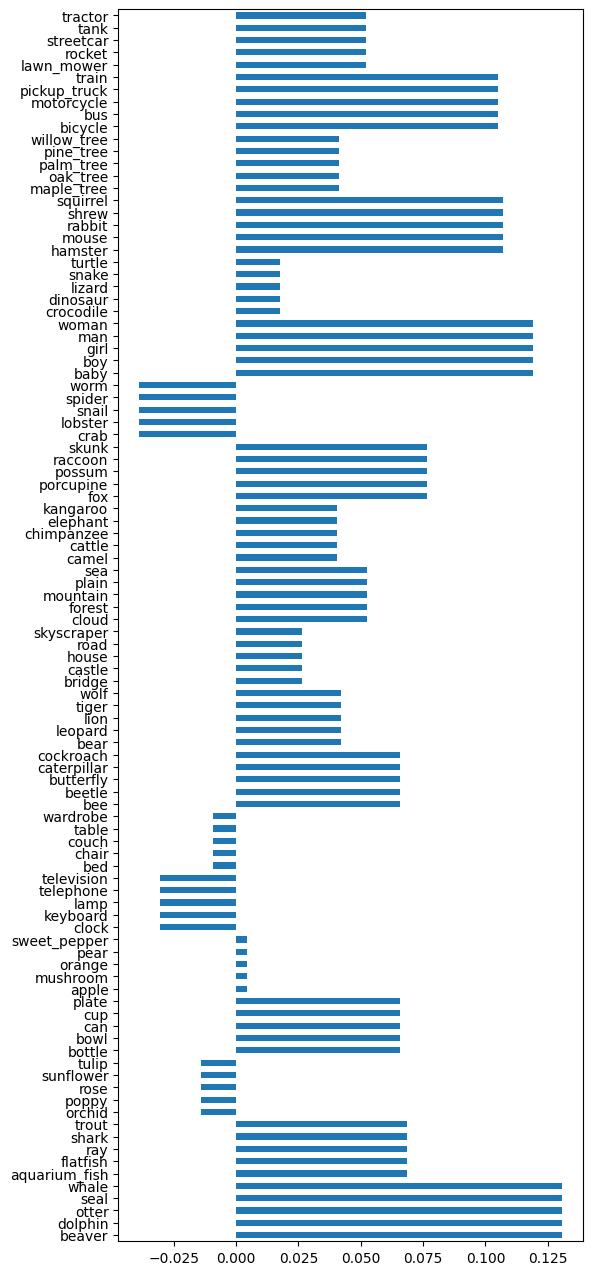

In [74]:
# График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса
df.sort_values(by=['c_label', 'CF_C'],ascending=True).plot.barh(y='CF_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса позволяет сделать вывод о том, какие категории лучше определяются при обучении на узких классах, а какие на широких. На узких классах лучше определяются (имеют положительное значение на графике) vehicles_2,vehicles_1, trees, small_mammals, reptiles, people, medium_mammals, large_omnivores_and_herbivores, large natural outdoor scenes, large_man-made_outdoor_things, large_carnivores, insects, fruit_and_vegetables, food_containers, fish, aquatic_mammals. Остальные классы лучше определяются при обучении на широких классах.